In [36]:
import numpy as nm
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as md
import statistics
import scipy.signal as ss
from pandas.plotting import autocorrelation_plot

In [37]:
def read_data(file_name):
    col_names = ['Year', 'Month', 'DateInFractionOfYear', 'MonthlyMeanTotalSunspotNumber',
                 'MonthlyMeanStandardDeviation', 'NumberOfObservations', 'DefinitiveProvisionalMarker']
    dataframe = pd.read_csv(file_name, names=col_names, delimiter=';')
    dataframe['Date'] = dataframe.Year.apply(str) + '-' + dataframe.Month.apply(str)
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataset = dataframe.set_index('Date')

    return dataset

In [38]:
sunspot_dataframe = read_data('data/SN_m_tot_V2.0.csv')
sunspot_dataframe.head()

,Year,Month,DateInFractionOfYear,MonthlyMeanTotalSunspotNumber,MonthlyMeanStandardDeviation,NumberOfObservations,DefinitiveProvisionalMarker
Date,,,,,,,
1749-01-01,1749,1,1749.042,96.7,-1.0,-1,1
1749-02-01,1749,2,1749.123,104.3,-1.0,-1,1
1749-03-01,1749,3,1749.204,116.7,-1.0,-1,1
1749-04-01,1749,4,1749.288,92.8,-1.0,-1,1
1749-05-01,1749,5,1749.371,141.7,-1.0,-1,1


In [39]:
def calculate_stats(data):
    print("Mean = " + str('{0:.2f}'.format(statistics.mean(data))))
    print("Median = " + str('{0:.2f}'.format(statistics.median(data))))
    print("Standard Deviation = " + str('{0:.2f}'.format(nm.std(data))))
    print("Variance = " + str('{0:.2f}'.format(statistics.variance(data))))
    print("Min = " + str('{0:.2f}'.format(min(data))))
    print("Max = " + str('{0:.2f}'.format(max(data))))

In [40]:
calculate_stats(sunspot_dataframe.MonthlyMeanTotalSunspotNumber)

Mean = 81.59
Median = 66.85
Standard Deviation = 67.80
Variance = 4597.58
Min = 0.00
Max = 398.20


In [41]:
def create_data_copy(data):
    df_copy = data.copy()
    df_copy.drop('Year', axis=1, inplace=True)
    df_copy.drop('Month', axis=1, inplace=True)
    df_copy.drop('DateInFractionOfYear', axis=1, inplace=True)
    df_copy.drop('MonthlyMeanStandardDeviation', axis=1, inplace=True)
    df_copy.drop('NumberOfObservations', axis=1, inplace=True)
    df_copy.drop('DefinitiveProvisionalMarker', axis=1, inplace=True)

    return df_copy

In [42]:
dataframe_copy = create_data_copy(sunspot_dataframe)
dataframe_copy.head()

,MonthlyMeanTotalSunspotNumber
Date,
1749-01-01,96.7
1749-02-01,104.3
1749-03-01,116.7
1749-04-01,92.8
1749-05-01,141.7


In [43]:
def sunspot_plot(data):
    peaks_negative, _ = ss.find_peaks(-data.MonthlyMeanTotalSunspotNumber, height=-12, threshold=None, distance=100)
    plt.figure(figsize=(14, 8))

    plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y.%m'))
    plt.gca().xaxis.set_major_locator(md.MonthLocator(interval=132))
    plt.plot(data.index, data.MonthlyMeanTotalSunspotNumber)
    plt.gcf().autofmt_xdate()

    plt.plot_date(data.index[peaks_negative], data.MonthlyMeanTotalSunspotNumber[peaks_negative], 'go',
                  label='negative peaks')

    plt.title("All Monthly Observations")
    plt.xlabel("Date")
    plt.ylabel("Monthly Mean Total Sunspot Number")
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

    return sunspot_dataframe.index[peaks_negative]

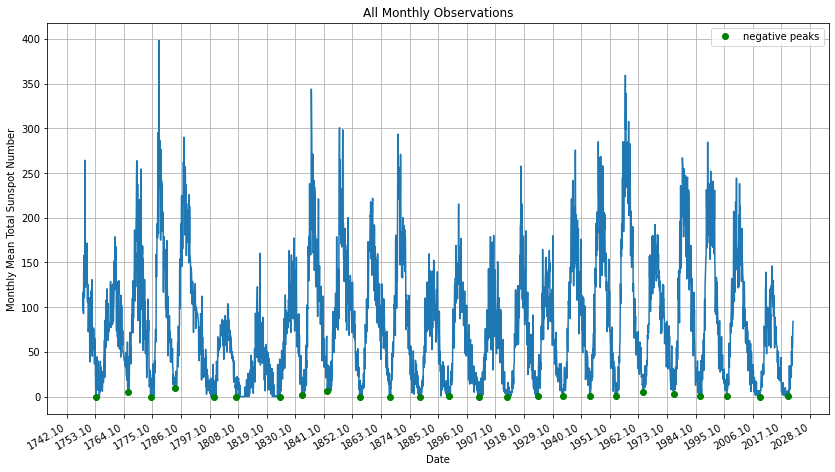

In [44]:
data_peaks = sunspot_plot(sunspot_dataframe)

In [45]:
def draw_boxplot(data, peaks):
    period = [0, 0, 0, 0, 0]
    temp = 0

    for p in range(5):
        period[p] = data.loc[(data.index >= peaks[temp]) & (data.index <= peaks[temp + 5])]
        period[p] = period[p].MonthlyMeanTotalSunspotNumber

        if temp >= 15:
            temp = temp + 4
        else:
            temp = temp + 5

    plt.figure(figsize=(14, 8))
    plt.boxplot(period, showmeans=True)
    plt.title("Boxplot")
    plt.xlabel("Period")
    plt.ylabel("Monthly Mean Total Sunspot Number")
    plt.show()

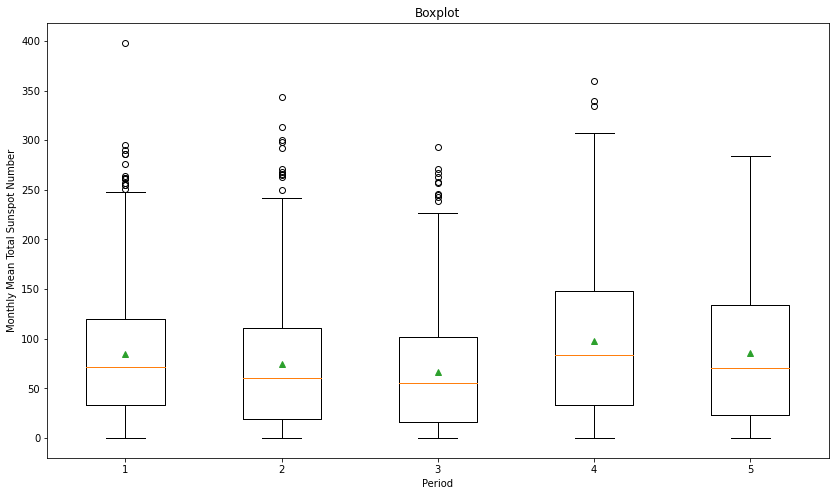

In [46]:
draw_boxplot(sunspot_dataframe, data_peaks)

In [47]:
def draw_autocorrelation_plot(data):
    plt.figure(figsize=(14, 8))
    autocorrelation_plot(data, color='dodgerblue')
    plt.title("Autocorrelation Plot")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.grid(True)
    plt.show()

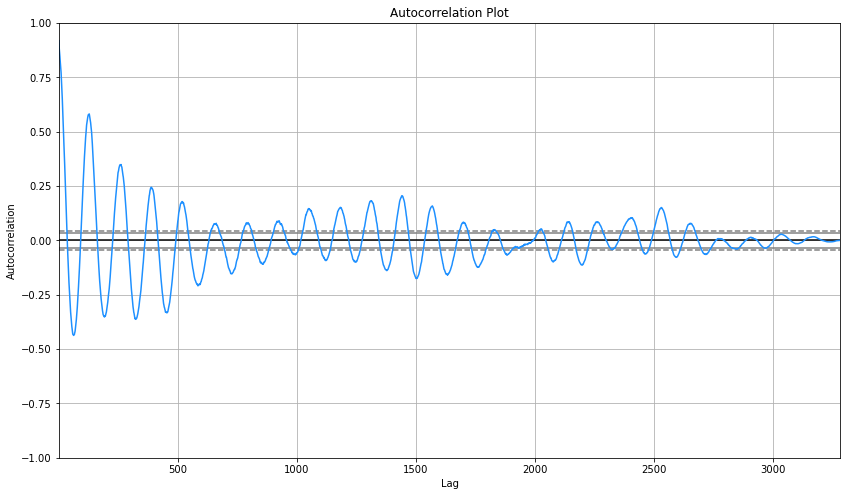

In [48]:
draw_autocorrelation_plot(dataframe_copy)

In [49]:
def draw_rolling_avg_plot(data):
    rolling_avg = data['MonthlyMeanTotalSunspotNumber'].rolling(window=12 * 11, closed='both', center=True).mean()
    rolling_avg.plot(figsize=(16, 6), grid=True, xlabel='Date', ylabel='Monthly Mean Total Sunspot Number',
                     title='11-year Moving Average of the Monthly Mean Total Sunspot Number')
    plt.show()

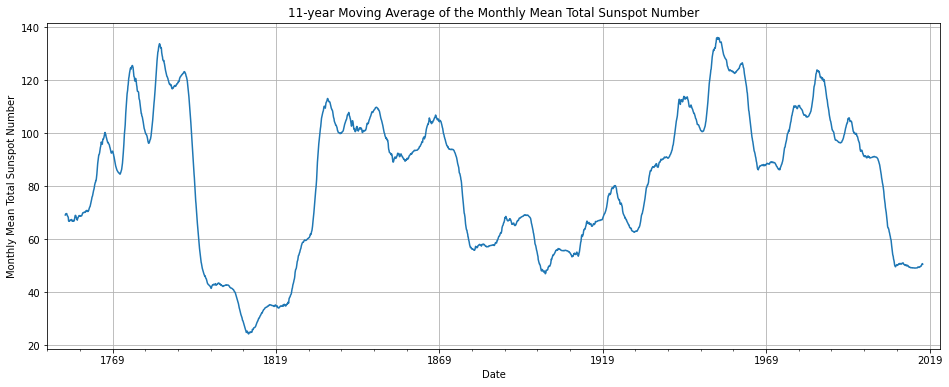

In [50]:
draw_rolling_avg_plot(dataframe_copy)

In [51]:
def draw_histogram(data):
    bins = nm.arange(0, 401, 10)
    data.hist(bins=bins, figsize=(15, 5), color='steelblue', edgecolor='darkslategrey', grid=False)
    plt.title("Frequency of Monthly Mean Total Sunspot Number - Histogram")
    plt.xlabel("Monthly Mean Total Sunspot Number")
    plt.ylabel("Frequency")
    plt.show()

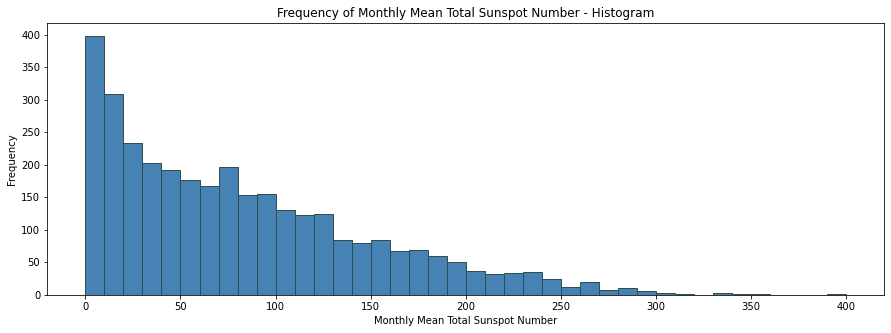

In [52]:
draw_histogram(dataframe_copy)

In [53]:
def find_cycles(data):
    lag_vals = nm.arange(12 * 15)
    autocorr_ser = nm.array([data['MonthlyMeanTotalSunspotNumber'].autocorr(lag=n) for n in lag_vals])
    years = ss.argrelextrema(autocorr_ser, nm.greater, order=2)[0][0] / 12
    print("Small solar cycle = " + str('{0:.2f}'.format(years)) + " years")

    lag_vals = nm.arange(1700)
    autocorr_ser = nm.array([data['MonthlyMeanTotalSunspotNumber'].autocorr(lag=n) for n in lag_vals])
    years = ss.argrelextrema(autocorr_ser, nm.greater, order=130)[0][0] / 12
    print("Large solar cycle = " + str('{0:.2f}'.format(years)) + " years")

In [54]:
find_cycles(dataframe_copy)

Small solar cycle = 10.67 years
Large solar cycle = 120.00 years
